<h1><center>Introduction: about  the problem,  multiclass classification, and Convolutional Neural Networks
</center></h1>

In this notebook we are going to use [https://keras.io/](Keras), a Python library for Convolution Neural Networks (CNNs, in short), Recursive Neural Networks RNNs, among other spatial-temporal models. 

The problem is the following:

>__`Problem statement:`__given a curve on an interval [a,b], classify it according to its number of critical points in the interval, that is: **0 whenever it has 0 critical points;      1 whenever it has 1 critical point;     or 2 if it has strictly more than 1 critical point.**
    
    
    
This is a classification problem, with three classes. Several things change in a multiclass classification when compared to binary classification, as we shall discuss next; the changes are small but important, and we will go slow in order to not overlook them.

Let's begin by importing some libraries

In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
import matplotlib.pyplot as plt
tf.reset_default_graph()

Now we generate some sample. The idea is: we give 5 points at random and plot a cubic spline that fits them. Then we find the critical points. 

For the interpolation part, I'm gonna use the following library

In [2]:
from scipy.interpolate import CubicSpline

First we define the interval $I = [0,10]$, and 5 points in it.

In [3]:
a, b = 0, 10
N = 20
interval = np.linspace(a,b, N)
x_ticks = np.linspace(1,9,5)

Now, in each one of these 5 points, we generate random numbers, that we will use to find interpolating cubic splines later on:

In [4]:
N_pop = 2000
X_points = 6*np.random.randn(5,N_pop)

Ok, we are ready to find the cubic splines. For example, if you would like to find the cubic splines passing through some points, you do

In [5]:
cs = CubicSpline(x_ticks,np.reshape(X_points[:,110],(-1,1)))

which gives something like this

Text(0, 0.5, 'f(x)')

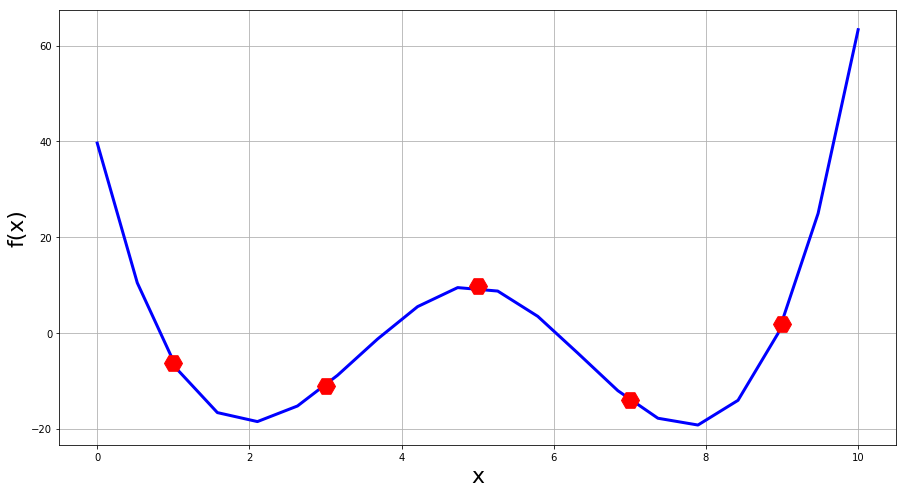

In [6]:
plt.figure(figsize=(15,8))
plt.plot(interval, cs(interval),lw=3,color='blue')
plt.plot(x_ticks,X_points[:,110].T,marker='H',linestyle='',color='red',markersize=18)
plt.grid(True)
plt.xlabel('x',size=22)
plt.ylabel('f(x)',size=22)

And now, if we want to find the critical points we do

In [7]:
z_roots = cs.derivative().roots()
print(z_roots)

[array([2.00443804, 4.93219054, 7.77004996])]


In fact, we would like to consider only critical points in the  interval [0,10], but this part is much easier, and I will point that out in the later code.

Alright, so we are ready to go. Let's do it in mass, that is, generate many interpolation points and find associated cubic spline interpolanting curves:

In [8]:
y = np.zeros([N_pop])

X_data = np.zeros((N_pop,len(interval)))
for k in range(N_pop):
    cs = CubicSpline(x_ticks,X_points[:,k])
    X_data[k,:]=cs(interval)
    z_roots = cs.derivative().roots()
    ## Now we count the number of critical points included in the interval a=0, b=10:
    y[k] = int(np.sum(1*(z_roots<=b)*(z_roots>=a))) 


Now we do two things: 
    
    1. We will truncate the number of roots to 3 in case of more than 3 roots;
    2. We will apply a one hot to the prediction class

In [9]:
y_truncated = np.clip(y,0,2)

We shall embed it in a higher dimensional space, because Keras use the format (batch, steps, channels). for instance, if we have a $2\times 2$ matrix, where each row is a data point with dimension $1\times 2$, we have 2 data points, that shall be rearranged as a 3D matrix of size (2, 1,2). This is done as in the following example:

In [10]:
A= np.array([[3,2],[4,6]])
A = np.reshape(A, (np.shape(A)[0], np.shape(A)[1],1))
print(A)

[[[3]
  [2]]

 [[4]
  [6]]]


In [11]:
X_data = np.reshape(X_data,(np.shape(X_data)[0],np.shape(X_data)[1],1))

Now that we have data, let's split the it into a test set and train set:

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split_sample= StratifiedShuffleSplit(n_splits=1, test_size=.3)

for train_index, test_index in split_sample.split(X_data,y_truncated):
    X_train,Y_train = X_data[train_index,:,:],y_truncated[train_index]
    X_test,Y_test = X_data[test_index,:,:],y_truncated[test_index]
    
    # For later, when we rund a lower dimensional prediction model
    X_points_train, X_points_test = X_points[:,train_index].T,X_points[:,test_index].T

Now we generate a one hot for each label representation: this will make the (new) labels pairwise  orthogonal and equidistant:

>__Remark (why to one-hot?):__ The main idea of one-hot encoding is finding a labeling system that is not ordered. For instance, then we have two classes only then all the points, that is, 0,1, are equidistant. When we have more than 2, that is not the case anymore. In order to represent k-points in an equidistant fashion, we embed them in a (k dimension) sphere, that the mathematicians represent as $S^{k-1}$. The reason for the $k-1$ index rather than $k$ is due to the manifold dimension. If you are not familiar with Differential/Riemmanian Geometry terminology, just think about the fact that, in this planet (a 3D object), we can find every point  only using 2 coordinates: longitude and latitude; the dimension 2 of the manifold is due to the number of coordinates whenever we locally representat is (as a 'chart').

I will run this part with a short Tensorflow code

In [13]:
tf.reset_default_graph()
z = tf.placeholder(name="z", shape=(None),dtype= tf.int32)
y_one_hot = tf.one_hot(z,3)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    Y_train = sess.run(y_one_hot, feed_dict={z:Y_train})
    Y_test = sess.run(y_one_hot, feed_dict={z:Y_test})

The one-hot encoding could also be done using the code

`Y_test = keras.utils.to_categorical(Y_test, num_classes=3)`


<h2><center>Convolutional NNs: why?
</center></h2>

A natural question here is **"why should we introduce a new model"**? Well... in this case it is natural to approximate the derivative of $f(\cdot)$ by a finite difference, like:
 $$f'(x) \approx \frac{f(x+h) - f(x-h)}{2h},$$
 
hence, in order to understand the behavior of $x \mapsto f'(x)$, we have to take into account the local behavior of $f(\cdot)$ in a neighborhood of $x$; **CNNs** provide a nonlocal model that accomplish that.
 
 We are woing to find weights W of size $1\times  3$ that will read the entry
 X  and give the appropriate outcome. For instance, the first layer will be of type
 
\begin{align}
Z^1 &= W^1 \ast X + b \\
 & A^1 = g(Z^1),
 \end{align}
 where $g(\cdot)$ is an appropriately chosen activation function.
 
 >__Remark (motivation for the model):__ the convolution structure in a CNN is essentially mimicking the layer structure in a NN.  Convolutional structure are relevant when one has an object whose structure is not perceived in a pointwise sense, but as groups of points. For instance, no one looks to pictures analysing pixel by pixel, but by looking at groups of pixels.
 
 In terms of layers, we are going to train a model like this
 
 $$ CNN \rightarrow Relu \rightarrow Maxpool \rightarrow Flatten \rightarrow Dense \rightarrow  softmax.$$

In [14]:
import keras
import graphviz

from keras import layers

#we add the following line of code, otherwise it complains that we are not running on the same graph
# see 
#https://stackoverflow.com/questions/51588186/keras-tensorflow-typeerror-cannot-interpret-feed-dict-key-as-tensor
from keras import backend as K

Using TensorFlow backend.


Let's define the model in Keras

In [15]:
def Predict_zeros(input_shape):
    X_input = keras.Input(input_shape)
    
    ## Now we pad the data
    X = keras.layers.ZeroPadding1D(2)(X_input)
    X = keras.layers.Conv1D(4,(3), strides=1,activation='relu',name='conv0')(X)
    
    ## max pool
    X = keras.layers.MaxPooling1D(stride=2,pool_size=2,padding='same')(X)
    
    ## Last layer
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(3,activation='softmax',name='fc')(X)
    
    model = keras.models.Model(input=X_input,output = X,name ='predict_zeros')
    return model

Now we fit this model to the data we have:

In [16]:
K.clear_session()
Predict_zeros = Predict_zeros((len(interval),1))

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2, padding="same", strides=2)`
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="predict_zeros", outputs=Tensor("fc...)`
  from ipykernel import kernelapp as app


In [17]:
Predict_zeros.compile(optimizer='adam',loss='categorical_crossentropy',metrics=["accuracy"])

In [18]:
Predict_zeros.fit(x = X_train, y = Y_train,epochs=40, batch_size=16)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
1400/1400 [==============================] - 0s 159us/step - loss: 2.9509 - accuracy: 0.4729
Epoch 2/40
1400/1400 [==============================] - 0s 107us/step - loss: 0.8085 - accuracy: 0.8314
Epoch 3/40
1400/1400 [==============================] - 0s 112us/step - loss: 0.5848 - accuracy: 0.8600
Epoch 4/40
1400/1400 [==============================] - 0s 121us/step - loss: 0.4565 - accuracy: 0.8850
Epoch 5/40
1400/1400 [==============================] - 0s 101us/step - loss: 0.3913 - accuracy: 0.8921
Epoch 6/40
1400/1400 [==============================] - 0s 101us/step - loss: 0.3633 - accuracy: 0.8979
Epoch 7/40
1400/1400 [==============================] - 0s 93us/step - loss: 0.3504 - accuracy: 0.8986
Epoch 8/40
1400/1400 [==============================] - 0s 109us/step - loss: 0.3404 - accuracy: 0.8986
Epoch 9/40
1400/1400 [==============================] - 0s 96us/step - loss: 0.3301 - accuracy: 0.8986
Epoch 10/40
1400/1

 Evaluate the model on the test data using `evaluate`


In [19]:
results = Predict_zeros.evaluate(X_test, Y_test)
print('test loss, test acc:', results)

600/600 [==============================] - 0s 77us/step
test loss, test acc: [0.2711054825782776, 0.8966666460037231]


Amazing! The accuracy is quite good. 

But now comes the question: is it possible to get a similar result just using the interpolation points? Essentially, the reduced points are enough to make the prediction.

<h1> <center>Prediction, using only interpolation points </center></h1>

Let's define a neural network (NN) in tensorflow. It starts with 5 nodes (that is, the interpolation points we have defined), and it has as output a one-hot vector in $S^2$, that is, 3 classes.



In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

To make a fair comparison, in the above CNN model we should the same number of variables to be optimized on. This is not hard to find:

In [21]:
print(Predict_zeros.summary())

Model: "predict_zeros"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 1)             0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 24, 1)             0         
_________________________________________________________________
conv0 (Conv1D)               (None, 22, 4)             16        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 44)                0         
_________________________________________________________________
fc (Dense)                   (None, 3)                 135       
Total params: 151
Trainable params: 151
Non-trainable params: 0
_______________________________________________________

>__Note:__ if you try to do the counting of number of variables, don't forget that maxpooling layers don't have optimization parameters.

Let's say that we would like 1 hidden layer. We would like to have more or less 151 variables to optimize on. Hence, we should have

$$5\times k + k\times 3 \approx 151$$

which gives (wounding up to integer) k= 20 as a decent choice.

In [22]:
predict_nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes= (20,3), random_state=1)

which has

In [23]:
predict_nn.hidden_layer_sizes

(20, 3)

In [24]:
predict_nn.fit(X_points_train,Y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [25]:
y_pred = predict_nn.predict(X_points_train)
print("Accuracy score training set:", accuracy_score(Y_train,y_pred))

y_pred = predict_nn.predict(X_points_test)
print("Accuracy score training set:", accuracy_score(Y_test,y_pred))

Accuracy score training set: 0.9921428571428571
Accuracy score training set: 0.955


Great! It seems that we don't need all the information used in the CNN model: the interpolation points already provide `high quality` information about the object. From another perspective, this simple exercise entices our intuition to the following fact: it seems to show that one can  reduce the dimension of the elements in the sample space, and with the project sample (in a lower dimensional space) encode a prediction model.

>__Remark:__ This is somewhat not very far from what I did in this project `The Rising Sun Envelope Method`
https://rafael-a-monteiro-math.github.io/Rising_Sun_Envelope_Method/
In this we reduce the dimension of each element in the sample space in order to feed it to a ML model (the prediction part is in progress, which is more straightforward: the hard part was doing the dimension reduction).

<h2> <center>Does the choice of interpolating points matter?</center></h2>

It is somewhat natural to ask whether or not the interpolating points, which in our case consisted of 5 points,  1, 3, 5, 7, and 9,  matter for the prediction. The answer is clearly yes, for if we had chosen among this 5 points the critical points (and allowing for repetition), we would always be able to find the right answer, with 100% accuracy.

The punch line is that the quality of the dimension reduction matter a lot: in case of functions, the choice for interpolation points is not always evident, as different interpolation points give different interpolating curves/approximations. The `Rising Sun Envelope Method` is an example of that, but many others can be seen in the literature: Lasso regressions (related to sparse regressions), filters used extensively in signal processing (low-pass, high-pass filters, etc). In other fields, like PDEs, the source of interpolation points is crucial, giving rise to <a href="https://en.wikipedia.org/wiki/Chebyshev_polynomials">Chebyshev polynomial based methods</a> or other methods that, in general, have a higher concentration of points along the boundary than in the "bulk" of the domain.

>(Exercise) Chebyshev poynomials (CP) in an interval $[a,b]$ have a curious feature: a CP of order $n-1$ (which is a polynomial of order $n-1$) is the best approximation to polynomials of order $n$ (see chapter 9 of the beautiful, but somewhat outdated, book by Peter Henrici, <a href="https://archive.org/details/ElementsOfNumericalAnalysis">Elements of Numerical Analysis</a> (which is still a great book, but so old that it is now public domain). The interesting thing about the nodes of the CP polynomials is that they accumulate in the boundary, as I mentioned before. CPs have many interesting properties and relations, and are extremely useful in many fields as PDEs, interpolation, ODEs etc, and are the heart of several numerical methods, like <a href="https://www.chebfun.org/"> Chebfun </a>. 